In [1]:
import uproot
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import sys, os
import importlib

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
from matplotlib import cm

## Define the class to fill particle information in to NumpyArray 

### User can use 
```
GenParticles = BrachGenParticles(file)
PID_all = GenParticles.PID
```
### to get all GenParticles PID array
### or
```
GenParticles = BrachGenParticles(file)
PID = GenParticles.PID_At(i)
```
### to get the GenParticles PID array in the ith event

In [2]:
class BrachGenParticles:
    def __init__(self,file):
        self.file = file
        self.length = len(file["Particle.Status"].array())
        self.Status = file["Particle.Status"].array()
        self.PID = file["Particle.PID"].array()
        self.M1 = file["Particle.M1"].array()
        self.M2 = file["Particle.M2"].array()
        self.D1 = file["Particle.D1"].array()
        self.D2  = file["Particle.D2"].array()
        self.PT = file["Particle.PT"].array()
        self.Eta =  file["Particle.Eta"].array()
        self.Phi = file["Particle.Phi"].array()
        self.Mass = file["Particle.Mass"].array()
        self.Labels = ["Status", "PID" , "M1", "M2", "D1", "D2", "PT", "Eta", "Phi", "Mass"]
        
    def length_At(self, i):
        return len(self.Status[i])
    def Status_At(self, i):
        return self.Status[i]
    def PID_At(self, i):
        return self.PID[i]
    def M1_At(self, i):
        return self.M1[i]
    def M2_At(self, i):
        return self.M2[i]
    def D1_At(self, i):
        return self.D1[i]
    def D2_At(self, i):
        return self.D2[i]
    def PT_At(self, i):
        return self.PT[i]
    def Eta_At(self, i):
        return self.Eta[i]
    def Phi_At(self, i):
        return self.Phi[i]
    def Mass_At(self, i):
        return self.Mass[i]
    
class BrachJet:
    def __init__(self,file):
        self.file = file
        self.length = len(file["Jet.PT"].array())
        self.PT = file["Jet.PT"].array()
        self.Eta =  file["Jet.Eta"].array()
        self.Phi = file["Jet.Phi"].array()
        self.Mass = file["Jet.Mass"].array()
        
    def PT_At(self, i):
        return self.PT[i]
    def Eta_At(self, i):
        return self.Eta[i]
    def Phi_At(self, i):
        return self.Phi[i]
    def Mass_At(self, i):
        return self.Mass[i]
    
class Event_Weight:
    def __init__(self,file):
        self.file = file
        self.length = len(file["Event.Weight"].array())
        self.Event_Weight = np.array(file["Event.Weight"].array())
        
    def Event_Weight_At(self, i):
        return self.Event_Weight[i]

## Define Function for Invariant Mass, Transverse Mass

### NOTE: the MT formula here is not compatible with MT in the collider physics, please modify this formula by yourself.

In [3]:
def M(pt1,eta1,phi1,m1,pt2,eta2,phi2,m2):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    
    return np.sqrt((e1+e2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2)
    
def MT(pt1,eta1,phi1,m1,pt2,eta2,phi2,m2):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    
    ET1, ET2  = np.sqrt(m1**2 + pt1**2), np.sqrt(m2**2 + pt2**2)
    MT = np.sqrt( (ET1+ET2)**2 - (px1+px2)**2 - (py1+py2)**2 )
    return MT
    
    

## Define Function for Check $r_{inv}$ and Preselection

In [4]:
def Check_r_inv(GenParticle):
    invis_count, vis_count = 0, 0
    Ndark = 0
    for i in range(GenParticle.length):
        for j in range(len(GenParticle.Status_At(i))):
            PID = GenParticle.PID_At(i)[j]
            M1 = GenParticle.M1_At(i)[j]
            M2 = GenParticle.M2_At(i)[j]
            D1 = GenParticle.D1_At(i)[j]
            D2 = GenParticle.D2_At(i)[j]
            status = GenParticle.Status_At(i)[j]
            
            if (abs(PID) == 4900111) and (abs( GenParticle.PID_At(i)[D1]) != 4900111) and (abs( GenParticle.PID_At(i)[D2]) != 4900111):
                if (abs(GenParticle.PID_At(i)[D1]) != 3) and (abs( GenParticle.PID_At(i)[D2]) != 3):
                    invis_count += 1

            if (abs(PID) == 4900111) and (abs( GenParticle.PID_At(i)[D1]) != 4900111) and (abs( GenParticle.PID_At(i)[D2]) != 4900111):
                if (abs( GenParticle.PID_At(i)[D1]) == 3) or (abs( GenParticle.PID_At(i)[D2]) == 3):
                    vis_count += 1

            if (abs(PID) == 4900113) and (abs( GenParticle.PID_At(i)[D1]) != 4900113) and (abs( GenParticle.PID_At(i)[D2]) != 4900113):
                if (abs( GenParticle.PID_At(i)[D1]) > 490000) or (abs( GenParticle.PID_At(i)[D2]) > 490000):
                    invis_count += 1

            if (abs(PID) == 4900113) and (abs( GenParticle.PID_At(i)[D1]) != 4900113) and (abs( GenParticle.PID_At(i)[D2]) != 4900113):
                if (abs( GenParticle.PID_At(i)[D1]) < 6) or (abs( GenParticle.PID_At(i)[D2]) < 6):
                    vis_count += 1

            if (abs(PID) == 4900211) and (status == 1):
                    Ndark += 1

            if (abs(PID) == 4900213) and (status == 1):
                    Ndark += 1
    
    print("There are {} events.".format(len(GenParticle.Status)))
    print("There are Dark meson {}  decay into invisible particle.".format(invis_count))
    print("There are Dark meson {}  decay into visible particle.".format(vis_count))
    print("r_inv = {:^4.4f} ".format(invis_count/(invis_count+vis_count)))
    
    print("There are {} stable Dark mesons.".format(Ndark))
    print("Average = {:^4.4f} ".format(Ndark/len(GenParticle.Status)))
    
    return invis_count/(invis_count+vis_count), Ndark/len(GenParticle.Status)



def Find_xdxd(GenParticle):
    m_xdxd = []
    for i in range(GenParticle.length):
        for j in range(len(GenParticle.Status_At(i))):
            PID = GenParticle.PID_At(i)[j]
            M1 = GenParticle.M1_At(i)[j]
            M2 = GenParticle.M2_At(i)[j]
            D1 = GenParticle.D1_At(i)[j]
            D2 = GenParticle.D2_At(i)[j]
            status = GenParticle.Status_At(i)[j]
            
            if PID == 4900101:
                tmp_1_pt = GenParticle.PT_At(i)[j]
                tmp_1_eta = GenParticle.Eta_At(i)[j]
                tmp_1_phi = GenParticle.Phi_At(i)[j]
                tmp_1_m = GenParticle.Mass_At(i)[j]
#                 print(tmp_1_pt,tmp_1_eta,tmp_1_phi,tmp_1_m)
                break
                
        for j in range(len(GenParticle.Status_At(i))):
            PID = GenParticle.PID_At(i)[j]
            M1 = GenParticle.M1_At(i)[j]
            M2 = GenParticle.M2_At(i)[j]
            D1 = GenParticle.D1_At(i)[j]
            D2 = GenParticle.D2_At(i)[j]
            status = GenParticle.Status_At(i)[j]
            
            
            if PID == -4900101:
                tmp_2_pt = GenParticle.PT_At(i)[j]
                tmp_2_eta = GenParticle.Eta_At(i)[j]
                tmp_2_phi = GenParticle.Phi_At(i)[j]
                tmp_2_m = GenParticle.Mass_At(i)[j]
#                 print(tmp_2_pt,tmp_2_eta,tmp_2_phi,tmp_2_m)
                break
                
                
        m_xdxd.append(M(tmp_1_pt,tmp_1_eta,tmp_1_phi,tmp_1_m,tmp_2_pt,tmp_2_eta,tmp_2_phi,tmp_2_m))
        
    return np.array(m_xdxd)
    
def Preselection(Jet):
    twojet_invariantmass = []
    survived_list = []
    for i in range(Jet.length):
        if len(Jet.PT_At(i)) < 2:
            continue

        if Jet.PT_At(i)[0] < 440 or Jet.PT_At(i)[1] < 60:
            continue

        if np.abs(Jet.Eta_At(i)[0]- Jet.Eta_At(i)[1]) > 1.2:
            continue

        twojet_invariantmass.append(M(Jet.PT_At(i)[0],Jet.Eta_At(i)[0],Jet.Phi_At(i)[0],Jet.Mass_At(i)[0],
                                      Jet.PT_At(i)[1],Jet.Eta_At(i)[1],Jet.Phi_At(i)[1],Jet.Mass_At(i)[1]))

        survived_list.append(i)

    print("There are {} events.".format(len(twojet_invariantmass)))
    
    return np.array(twojet_invariantmass), np.array(survived_list)

## Import File

In [8]:
path = "/home/MG5_Study_Group/ROOT/author"
filepath_3_5 = path + "/SVJ_3_5.root"

file_3_5 = uproot.open(filepath_3_5)["Delphes;1"]


#  Print the Branch in the Delphes

In [36]:
# file_3_5.show()

## Load event via class

In [9]:
GenParticle_3_5, Jet_3_5, Event_Weight_3_5 = BrachGenParticles(file_3_5), BrachJet(file_3_5), Event_Weight(file_3_5) 


# Check the number of Event

In [12]:
print("There are {} event in this file. ".format(len(GenParticle_3_5.Status)))

There are 14860 event in this file. 


# Print the Truth Record in an Event

In [ ]:
GenParticle = GenParticle_3_5
print("There are {} information in this event.".format(len(GenParticle.Status[0])))
print("GenParticle Information")
print("{:^5}{:^7}{:^7}{:^7}{:^7}{:^7}{:^7}{:^8}{:^8}{:^8}{:^8}".format("#","Status","PID", "M1", "M2", "D1", "D2", "PT", "Eta","Phi", "Mass"))

index = 0 ## which event you want to print out

for j in range(len(GenParticle.Status_At(index))):
    print("{:^5}{:^7}{:^7}{:^7}{:^7}{:^7}{:^7}{:^8.5}{:^8.5}{:^8.5}{:^8.5}".format( \
        j, GenParticle.Status_At(index)[j],  GenParticle.PID_At(index)[j], GenParticle.M1_At(index)[j], GenParticle.M2_At(index)[j],
         GenParticle.D1_At(index)[j], GenParticle.D2_At(index)[j],  GenParticle.PT_At(index)[j],  GenParticle.Eta_At(index)[j], GenParticle.Phi_At(index)[j], GenParticle.Mass_At(index)[j]))



## Findin the first two Xd(`4900101`) and $\bar{\mathrm{Xd}}$(`-4900101`) in the truth record table for invariant mass calculation.

In [13]:
m_dxdx = Find_xdxd(GenParticle_3_5)

## Calculate the number of event for event weight 
## Luminosity $\mathcal{L}$ = 37 $fb^{-1}$

In [64]:
weight_03_5 = Event_Weight_3_5.Event_Weight/20000

## Example 1: Plot in differential number of event

total events: 14860 


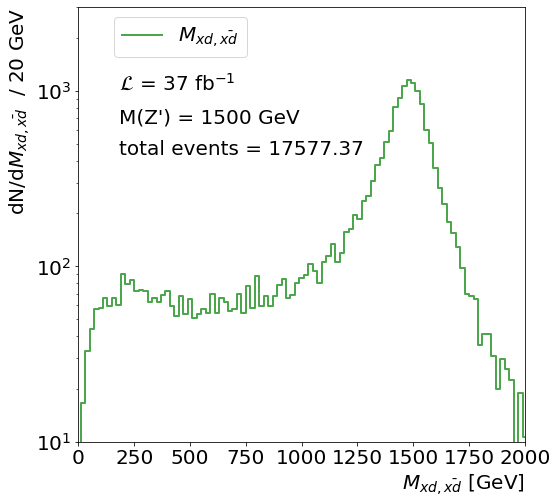

In [91]:
plt.figure(figsize=(8,8)) # plotsize

print("total events: {} ".format(len(m_dxdx)))

bin_size = np.linspace(0,5000,251)
hist, bins = np.histogram(m_dxdx, bins=bin_size, weights = weight_03_5*37*1000)
plt.step(bins[:-1], hist.astype(np.float32),color = "green", where='mid',linewidth=2, alpha=0.7,label="$M_{xd,\\bar{xd}}$") 


plt.text(180, 1000, "$\mathcal{L}$ = 37 $\mathrm{fb}^{-1}$", fontsize=20)
plt.text(180, 650, "M(Z') = 1500 GeV", fontsize=20)
plt.text(180, 430, "total events = " + str(np.round(np.sum(hist.astype(np.float32)),2)), fontsize=20)

plt.legend(bbox_to_anchor=(0.4, 1),ncol=2,fontsize=20)
# plt.legend(ncol=2,fontsize=25)# plot label tag
plt.yscale('log') 
# plt.xscale('log') 
plt.xlabel("$M_{xd,\\bar{xd}}$ [GeV]" , fontsize=20, horizontalalignment='right',x=1)  # plot x-axis label
plt.ylabel("dN/d$M_{xd,\\bar{xd}}$  / 20 GeV ", fontsize=20, horizontalalignment='right',y=1)  # plot y-axis label
plt.xticks(fontsize=20)   # set x-ticks size
plt.yticks(fontsize=20)   # set y-ticks size 
plt.xlim((0,2000))
plt.ylim((10,3000))
# plt.savefig("./invariant_mass_SVJ.png")  #save figure as png
plt.show()

## Example 2: Plot in normalized to one

### You can check the distrubution won't changed no matter the event weight is considered or not.

total events: 14860 


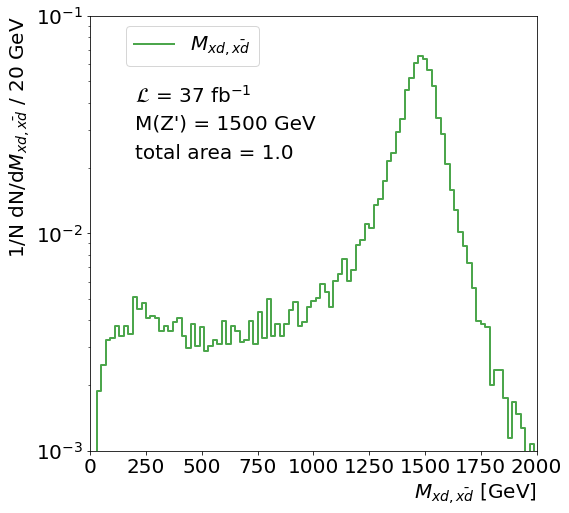

In [95]:
plt.figure(figsize=(8,8)) # plotsize

print("total events: {} ".format(len(m_dxdx)))

bin_size = np.linspace(0,5000,251)

# hist, bins = np.histogram(m_dxdx, bins=bin_size, weights = weight_03_5)
hist, bins = np.histogram(m_dxdx, bins=bin_size)

plt.step(bins[:-1], hist.astype(np.float32)/np.sum(hist),color = "green", where='mid',linewidth=2, alpha=0.7,label="$M_{xd,\\bar{xd}}$") 


plt.text(200, 0.04, "$\mathcal{L}$ = 37 $\mathrm{fb}^{-1}$", fontsize=20)
plt.text(200, 0.03, "M(Z') = 1500 GeV", fontsize=20)
plt.text(200, 0.022, "total area = " + str(np.round(np.sum(hist.astype(np.float32)/np.sum(hist)),2)), fontsize=20)

plt.legend(bbox_to_anchor=(0.4, 1),ncol=2,fontsize=20)
# plt.legend(ncol=2,fontsize=25)# plot label tag
plt.yscale('log') 
# plt.xscale('log') 
plt.xlabel("$M_{xd,\\bar{xd}}$ [GeV]" , fontsize=20, horizontalalignment='right',x=1)  # plot x-axis label
plt.ylabel("1/N dN/d$M_{xd,\\bar{xd}}$ / 20 GeV ", fontsize=20, horizontalalignment='right',y=1)  # plot y-axis label
plt.xticks(fontsize=20)   # set x-ticks size
plt.yticks(fontsize=20)   # set y-ticks size 
plt.xlim((0,2000))
plt.ylim((0.001,0.1))
# plt.savefig("./invariant_mass_SVJ.pdf")  #save figure as pdf
plt.show()

## Example 3: Plot in differential cross section
### Please check that the area under the curve is total cross section.
 

total events: 14860 


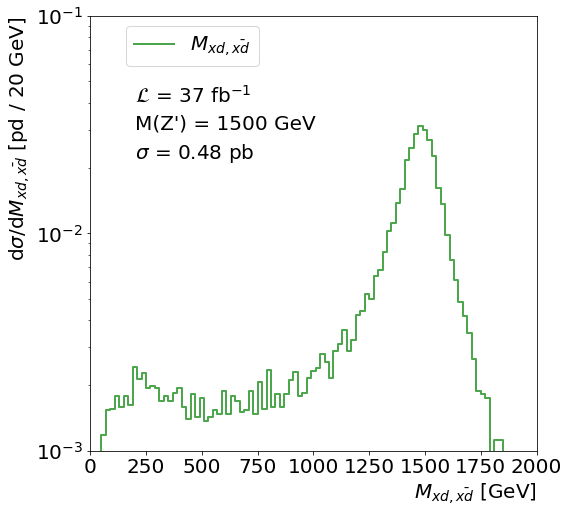

In [100]:
plt.figure(figsize=(8,8)) # plotsize

print("total events: {} ".format(len(m_dxdx)))

bin_size = np.linspace(0,5000,251)

hist, bins = np.histogram(m_dxdx, bins=bin_size, weights = weight_03_5)

plt.step(bins[:-1], hist.astype(np.float32),color = "green", where='mid',linewidth=2, alpha=0.7,label="$M_{xd,\\bar{xd}}$") 


plt.text(200, 0.04, "$\mathcal{L}$ = 37 $\mathrm{fb}^{-1}$", fontsize=20)
plt.text(200, 0.03, "M(Z') = 1500 GeV", fontsize=20)
plt.text(200, 0.022, "$\sigma$ = " + str(np.round(np.sum(hist)[0],2)) + " pb", fontsize=20)

plt.legend(bbox_to_anchor=(0.4, 1),ncol=2,fontsize=20)
# plt.legend(ncol=2,fontsize=25)# plot label tag
plt.yscale('log') 
# plt.xscale('log') 
plt.xlabel("$M_{xd,\\bar{xd}}$ [GeV]" , fontsize=20, horizontalalignment='right',x=1)  # plot x-axis label
plt.ylabel("d$\sigma$/d$M_{xd,\\bar{xd}}$ [pd / 20 GeV]", fontsize=20, horizontalalignment='right',y=1)  # plot y-axis label
plt.xticks(fontsize=20)   # set x-ticks size
plt.yticks(fontsize=20)   # set y-ticks size 
plt.xlim((0,2000))
plt.ylim((0.001,0.1))
# plt.savefig("./invariant_mass_SVJ.pdf")  #save figure as pdf
plt.show()

## Check the $r_{inv}$

In [50]:
Check_r_inv(GenParticle_3_5)


There are 14860 events.
There are Dark meson 29205  decay into invisible particle.
There are Dark meson 67733  decay into visible particle.
r_inv = 0.3013 
There are 58410 stable Dark mesons.
Average = 3.9307 


(0.3012750417792816, 3.930686406460296)

In [13]:
Lambda_d = [1,5,10,50,100,150,200,250,300,350]
for i, lambda_d in enumerate(Lambda_d):
    print("lambda: {:^7.3f}  alpha:{:^7.3f}".format(Lambda_d[i],np.pi*2/((11./3.*2-2./3.*2)*np.log(1000./lambda_d))))


lambda:  1.000   alpha: 0.152 
lambda:  5.000   alpha: 0.198 
lambda: 10.000   alpha: 0.227 
lambda: 50.000   alpha: 0.350 
lambda: 100.000  alpha: 0.455 
lambda: 150.000  alpha: 0.552 
lambda: 200.000  alpha: 0.651 
lambda: 250.000  alpha: 0.755 
lambda: 300.000  alpha: 0.870 
lambda: 350.000  alpha: 0.997 
